概要：上节学习了逻辑回归分类模型，本节学习决策边界。

1.设置绘图环境。

In [76]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2.导入鸢尾花数据集。这是一个著名的数据集，其中包含 150 朵三种
不同的鸢尾花的萼片和花瓣的长度和宽度。这三种鸢尾花为：Setosa，Versicolor，
Virginica。

In [77]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [78]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [79]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [80]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

我们看到鸢尾花有三种类型，分别是setosa, versicolor, virginica，特征变量依次是花萼长度（sepal length），花萼宽度（sepal width），花瓣长度（petal length），花瓣宽度（petal width）。

同时观察标签iris.target，发现分类顺序没有打乱，所以要做乱序操作，同时每种分类的样本数量要均匀：

In [81]:
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

iris = pd.DataFrame(np.c_[iris.data, iris.target], columns=['sepal length', 'sepal width', 'petal length', 'petal width', 'type'])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(iris, iris["type"]):
    strat_train_set = iris.loc[train_index]
    strat_test_set = iris.loc[test_index]

X_train, y_train = strat_train_set, strat_test_set

In [82]:
X_train["type"].value_counts() / len(X_train)

1.0    0.333333
2.0    0.333333
0.0    0.333333
Name: type, dtype: float64

训练集有120个样本，样本很平均。

In [83]:
iris.head()

,sepal length,sepal width,petal length,petal width,type
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003EB05FD0>,
      dtype=object)

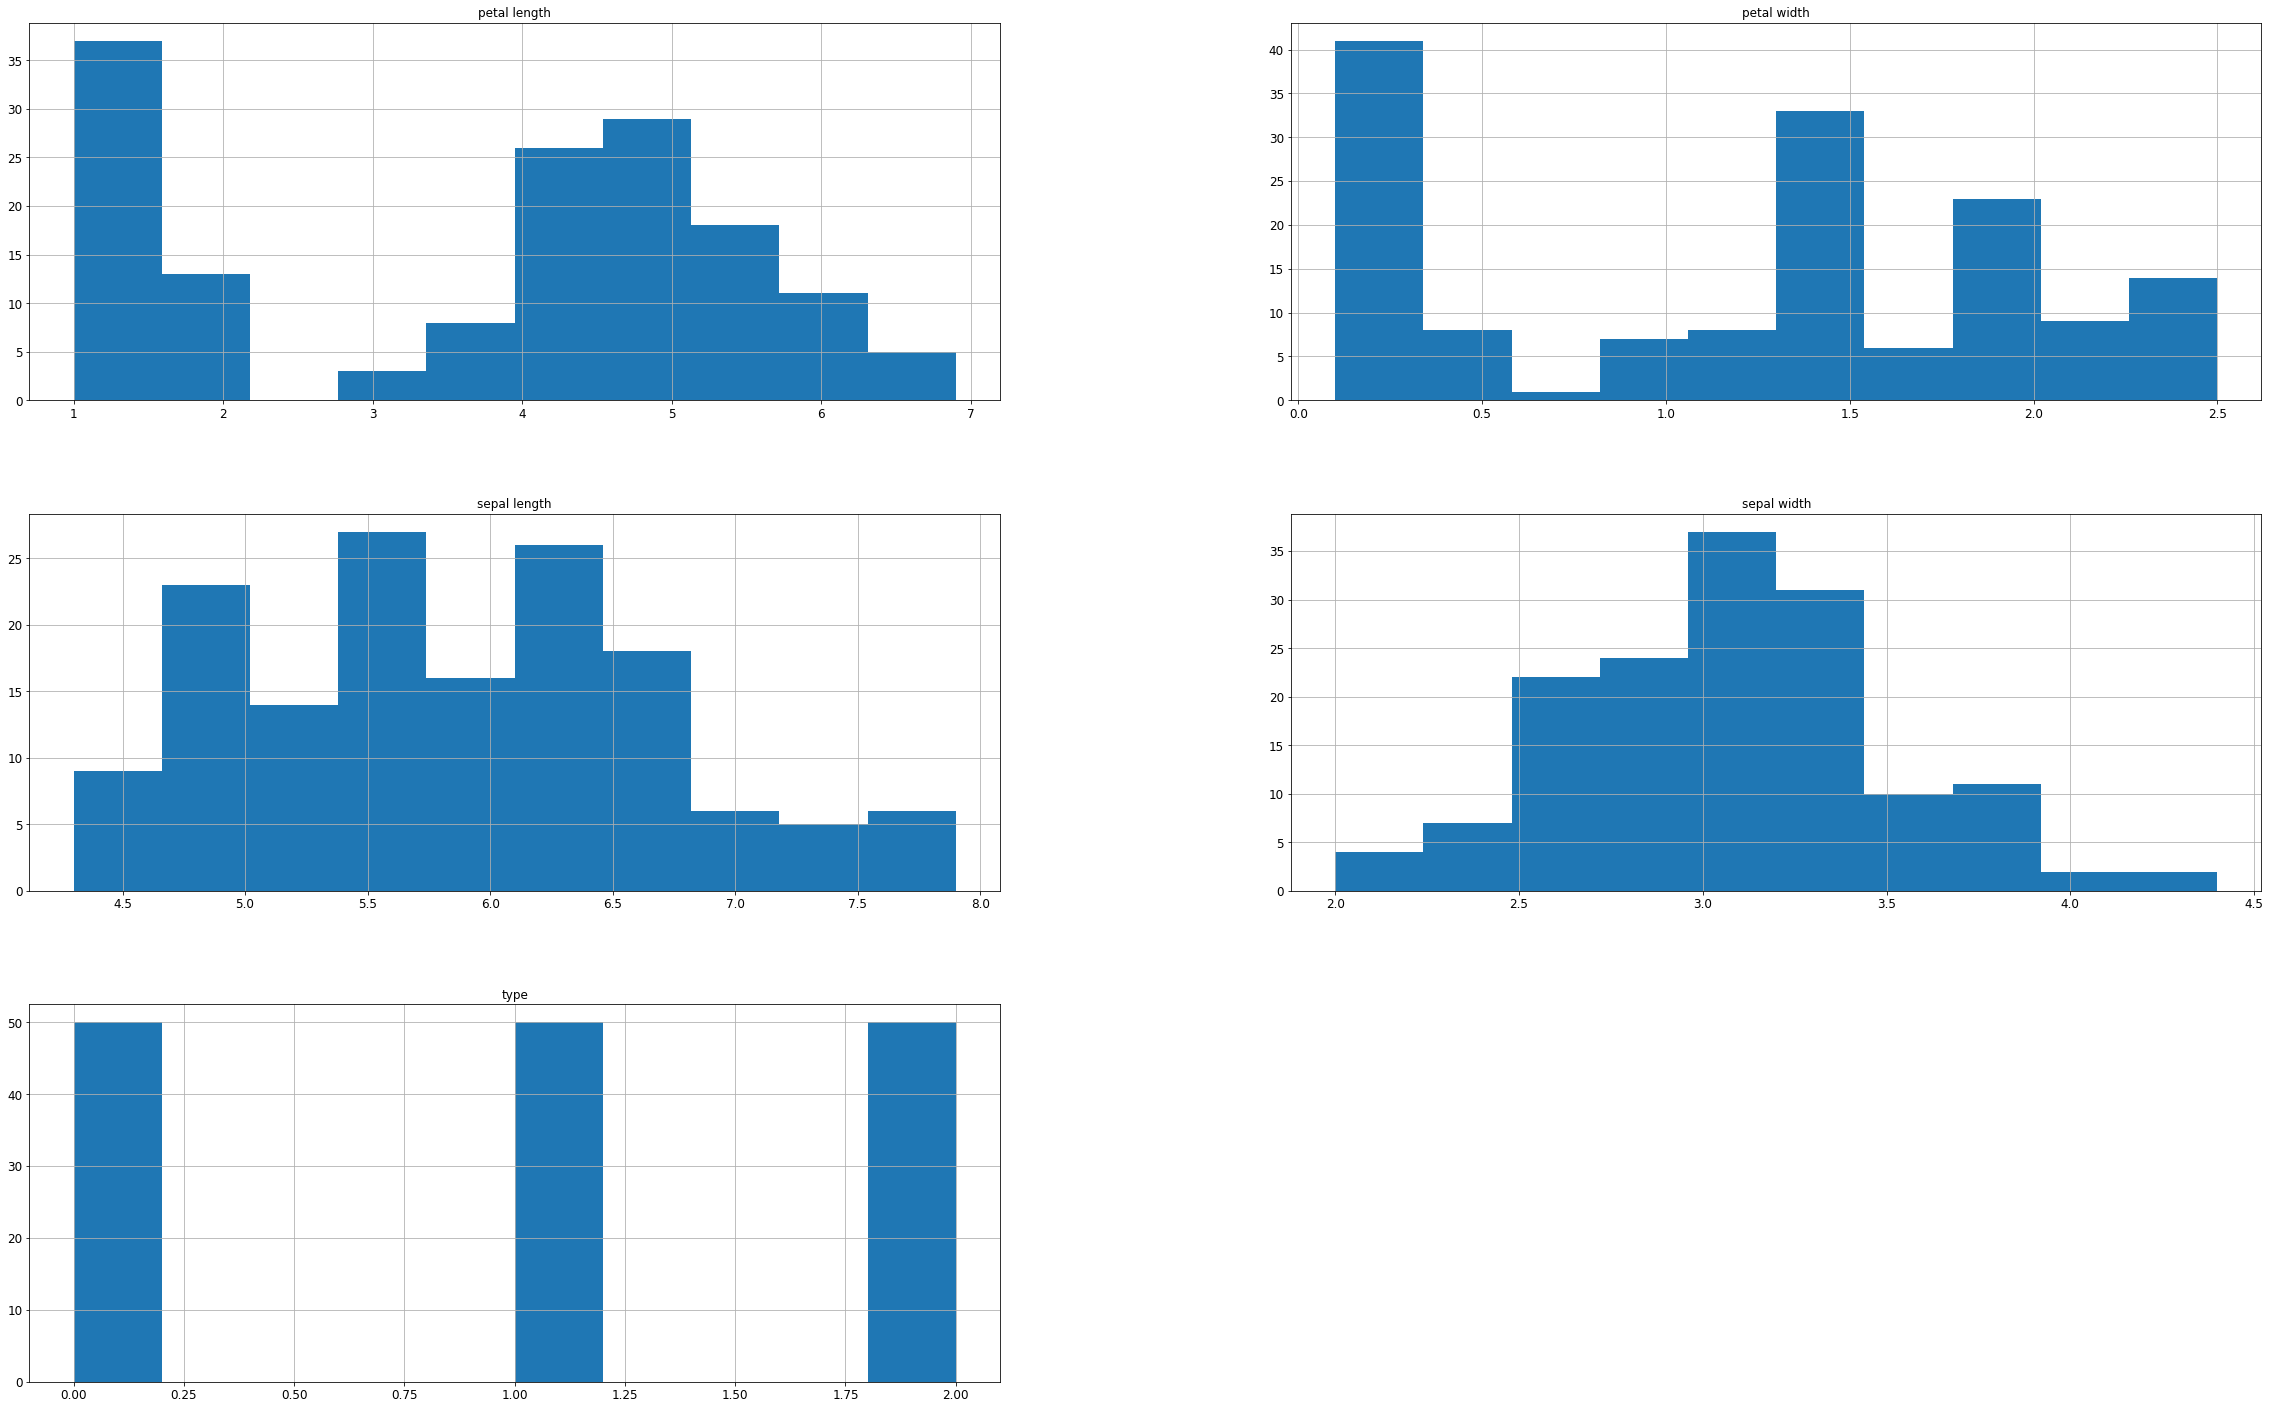

In [84]:
iris.hist(bins=10, figsize=(40, 25))

以上是特征的样本分布，可以看到，花瓣长度在1-2cm和4-5cm的样本占了一半以上；而花萼的特征比较集中，长度主要集中在4.5-7cm。

In [85]:
corr_type = iris.corr()

corr_type['type'].sort_values(ascending=False)

type            1.000000
petal width     0.956547
petal length    0.949035
sepal length    0.782561
sepal width    -0.426658
Name: type, dtype: float64

可以看到，对类型最有影响的特征是花瓣宽度和长度，然后是花萼的长度和宽度，注意类型和花萼宽度呈负相关性。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003ED4CB00>,
      dtype=object)

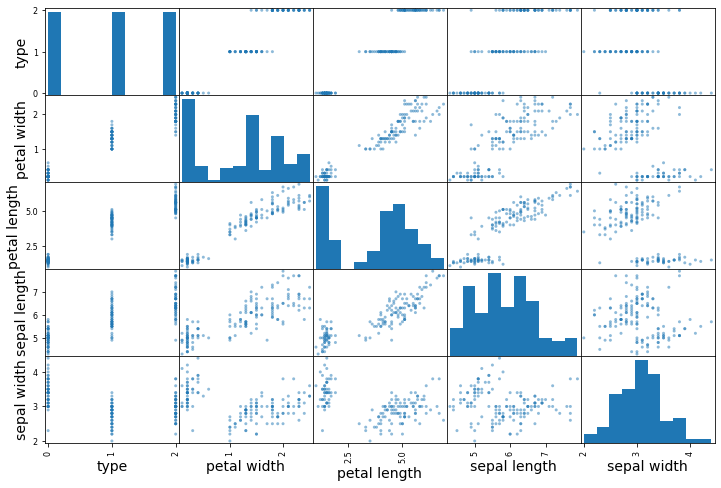

In [86]:
from pandas.plotting import scatter_matrix

attributes = ["type", "petal width", "petal length",
              "sepal length", "sepal width"]
scatter_matrix(iris[attributes], figsize=(12, 8))

从第一行图像上可以看到，点很集中并且具有方向性。

3.我们用梯度下降算法来训练模型。

In [87]:
from sklearn.linear_model import SGDClassifier

y_train = X_train["type"].copy()
X_train = X_train.drop("type", axis=1)

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

训练好了，测试一下：

In [97]:
X_train_0 = np.array(X_train.loc[0])

In [99]:
sgd_clf.predict(X_train_0.reshape(1, -1))

array([0.])

In [100]:
y_train[0]

0.0

X_train[10]的类型正确，是setosa(分类序号是0)。

进行一下交叉验证：

In [101]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.42857143, 0.66666667, 0.66666667])

准确率不高。

使用混淆矩阵来评估分类器：

In [102]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
y_train_pred[0:20]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1.])

In [103]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[30, 10,  0],
       [ 3, 27, 10],
       [ 0, 27, 13]], dtype=int64)

In [ ]:
我们看到准确率和召回率都不高。

4.使用逻辑回归模型。

In [119]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="liblinear", random_state=42, multi_class='auto')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [120]:
cross_val_score(log_reg, X_train, y_train, cv=3, scoring="accuracy")

array([0.97619048, 0.92307692, 1.        ])

In [121]:
y_train_pred = cross_val_predict(log_reg, X_train, y_train, cv=3)
y_train_pred[0:20]

array([0., 2., 1., 0., 1., 2., 1., 2., 2., 2., 2., 1., 1., 1., 1., 0., 0.,
       2., 2., 0.])

In [122]:
confusion_matrix(y_train, y_train_pred)

array([[40,  0,  0],
       [ 0, 36,  4],
       [ 0,  0, 40]], dtype=int64)

准确率和召回率都不错。

下面我们检查单个分类Virginica（分类编号是2）：

In [123]:
X = X_train.iloc[:, 3:]  # 只有“花瓣宽度”特征
y = (y_train == 2).astype(np.int)  # 1 if Iris-Virginica, else 0

In [124]:
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

我们来看看模型估计的花瓣宽度从 0 到 3 厘米的概率估计：

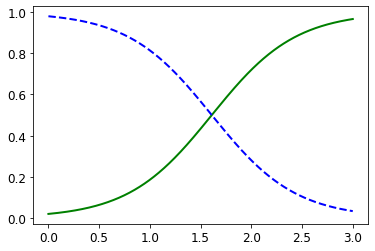

In [127]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")

In [136]:
decision_boundary

array([1.61261261])

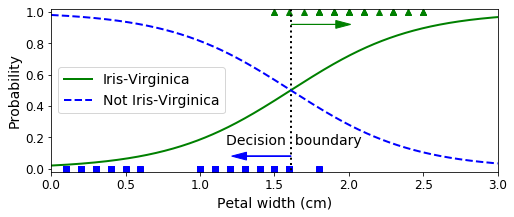

In [141]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

Virginica 花的花瓣宽度（用三角形表示）在 1.4 厘米到 2.5 厘米之间，而其他种类的花（由
正方形表示）通常具有较小的花瓣宽度，范围从 0.1 厘米到 1.8 厘米。注意，它们之间会有一
些重叠。在大约 2 厘米以上时，分类器非常肯定这朵花是Virginica花（分类器此时输出一个非
常高的概率值），而在1厘米以下时，它非常肯定这朵花不是 Virginica 花（不是 Virginica 花
有非常高的概率）。在这两个极端之间，分类器是不确定的。

因此，
在 1.6 厘米左右存在一个决策边界，这时两类情况出现的概率都等于 50%：

In [142]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

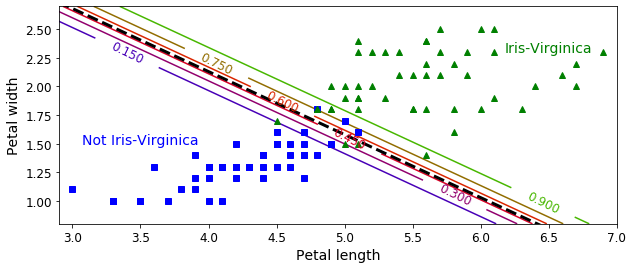

In [158]:
iris = datasets.load_iris()

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="liblinear", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

中间的虚线就是决策边界。